## Installations

In [ ]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

✨🍰✨ Everything looks OK!


In [ ]:
import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge numpy matplotlib mdtraj openmm cudatoolkit=11.2 openmmforcefields openmm-plumed=1.0
    !conda install -q -y -c pytorch pytorch=1.11

    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False

!pwd

# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *

# required for analysis
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

Dependencies successfully installed and imported!
/content


time taken to run: 65.56156259399995


In [ ]:
!git clone https://github.com/Suemin-Lee/SPIB_kinetics.git
%cd SPIB_kinetics

fatal: destination path 'SPIB_kinetics' already exists and is not an empty directory.
/content/SPIB_kinetics


In [ ]:
%cd /SPIB_kinetics

[Errno 2] No such file or directory: '/SPIB_kinetics'
/content/SPIB_kinetics


In [ ]:
from FKBP_openmm.MDSimulation import MDSimulation
import time
from IPython.display import clear_output

In [ ]:
%%bash
for i in {2..4}; do
  cp -r simulation/initial_trial/initial_trial1 simulation/initial_trial/initial_trial$i
done

#### SIMULATION PARAMETERS + FILES

In [ ]:
simutlation_steps = 1000000 # 1000000*0.002 ps >> 2000ps = 2ns
plumed_file_name = 'plumed_initial.dat'
threshold_val = 1.8 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation = 4
dir_path = '/initial_trial'

#### RUN FIRST SET OF SIMULATION (MetaD with Trial Variables)

In [ ]:
# Define your simulation steps as a separate function
def run_simulation_round(i, simutlation_steps, plumed_file_name, threshold_val,dir_path):
    clear_output(wait=True)
    print('***** Currently Running %i round of simulation******' % i)
    sim_directory = dir_path+'%i' % i
    md_sim = MDSimulation(work_dir= '/simulation'+dir_path + sim_directory)

    with md_sim.working_directory():
        md_sim.remove_previous_old_files()  # if exist, delete old files

        # Simulation Set-Up
        simulation = md_sim.simulation_preperation(equilibration=False)
        positions = simulation.context.getState(getPositions=True).getPositions()

        print("Simulating...")
        # Placeholder for simulation execution. Replace with your actual simulation call
        md_sim.run_MD(simulation, positions, nsteps=simutlation_steps, report_steps=False, committor=True,
                      use_plumed=True, plumed_file=plumed_file_name, stride=500, threshold=threshold_val)

        md_sim.remove_last_line()
md_sim = MDSimulation()

In [ ]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps **** =   500 / 1000000
      ligand location = 0.69      
 ****  Current steps **** =   1000 / 1000000
      ligand location = 0.65      
 ****  Current steps **** =   1500 / 1000000
      ligand location = 0.76      
 ****  Current steps **** =   2000 / 1000000
      ligand location = 0.70      
 ****  Current steps **** =   2500 / 1000000
      ligand location = 0.71      
 ****  Current steps **** =   3000 / 1000000
      ligand location = 0.75      
 ****  Current steps **** =   3500 / 1000000
      ligand location = 0.69      
 ****  Current steps **** =   4000 / 1000000
      ligand location = 0.65      
 ****  Current steps **** =   4500 / 1000000
      ligand location = 0.66      
 ****  Current steps **** =   5000 / 1000000
      ligand l

## Select appropriate OPs for SPIB tranining

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
from sklearn.cluster import KMeans
from itertools import groupby
import sys
import os

In [ ]:
# !pwd
%cd content/SPIB_kinetics/

/content/SPIB_kinetics


In [ ]:
!pwd
# %cd ../../

/content/SPIB_kinetics


In [ ]:
orginal_path = os.path.abspath('.')

data_list=[]
data_list_str=[]

for i in range(1,5):
    print(i)
    sim_path = '/simulation/initial_trial/initial_trial%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()

    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

1
2
3
4


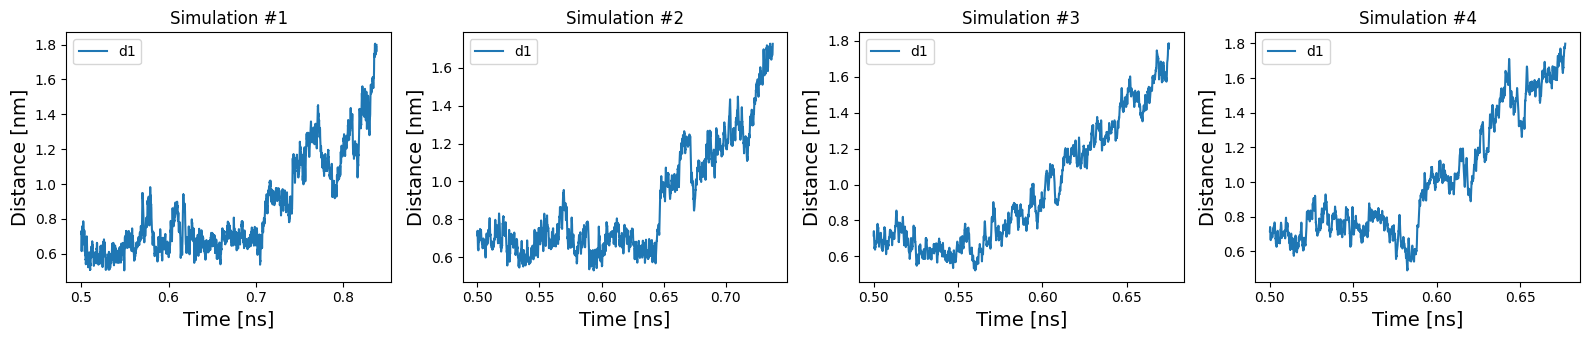

In [ ]:
# visualize the data and also initiate K-mean Clustering +Labeling

work_dir = '/SPIB_training/SPIB01'
os.chdir(orginal_path+work_dir)

plt.figure(figsize=(16,3.5))

for i, simulation_data in enumerate(data_list):
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-3]] # take time and the 426th colums of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]]
    bias_distance = simulation_data[:,[0,-4]]
    traj_raw = simulation_data[:,[-3,-4]]

    time = bias_distance[:,0]/1000

    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

    ######
    # One-hot encoded initial state assignment: Using K-mean clustering
    ######
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)

    distance_simulation_data = simulation_data[:,1:29]

    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()
# Combine all SPIB output data files for all 4 trajectories
concatenate_data = np.concatenate(data_list, axis=0)[:,1:29]

concatenate_data_mean = np.mean(concatenate_data, axis=0)
concatenate_data_std = np.std(concatenate_data, axis=0)

np.save('data/FKBP_distance_data_mean.npy', concatenate_data_mean)
np.save('data/FKBP_distance_data_std.npy', concatenate_data_std)


In [ ]:
!pwd

/content/SPIB_kinetics/SPIB_training/SPIB01


In [ ]:
# %cd /content/SPIB_kinetics/SPIB_training/SPIB01

## RUN SPIB stage 1

In [ ]:
# # run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


tensor([0.0000, 0.0000, 0.0000, 0.5867, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0524, 0.3609, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.662398
Update lr to 0.000010
Epoch: 1

Iteration 500:	Time 1.569156 s
Loss (train) 3.009770	KL loss (train): 2.642997
Reconstruction loss (train) 3.009506
Loss (test) 2.996370	KL loss (test): 2.614009
Reconstruction loss (test) 2.996109
tensor([0.0147, 0.0000, 0.0000, 0.5754, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0817, 0.3282, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.047591
Update lr to 0.000010
Epoch: 2

tensor([5.9167e-01, 0.0000e+00, 0.0000e+00, 1.1006e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2411e-05, 0.0000e+00, 1.4198e-01,
        2.5529e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])
State population change=0.812

In [ ]:
%cd SPIB_training/SPIB01/

/content/SPIB_kinetics/SPIB_training/SPIB01


## Generate Plume file from learn RC for MetaD

In [ ]:
!python plumed_generator.py

===== First updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.28038415 0.282243  ]


In [ ]:
!mv data/plumed_metaD_ANN.dat ../../simulation/01_metaD/01_metaD1
%cd ../../

/content/SPIB_kinetics


## Prepare for first SPIB stage of metadynmaics

In [ ]:
%%bash
for i in {2..4}; do
    cp -r simulation/01_metaD/01_metaD1 simulation/01_metaD/01_metaD$i
done

In [46]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 500000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat'
threshold_val = 1.8 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 4
dir_path = '/01_metaD'

In [45]:
!pwd

/content/SPIB_kinetics


In [48]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps **** =   500 / 500000
      ligand location = 0.60      
 ****  Current steps **** =   1000 / 500000
      ligand location = 0.71      
 ****  Current steps **** =   1500 / 500000
      ligand location = 0.75      
 ****  Current steps **** =   2000 / 500000
      ligand location = 0.65      
 ****  Current steps **** =   2500 / 500000
      ligand location = 0.76      
 ****  Current steps **** =   3000 / 500000
      ligand location = 0.75      
 ****  Current steps **** =   3500 / 500000
      ligand location = 0.80      
 ****  Current steps **** =   4000 / 500000
      ligand location = 0.76      
 ****  Current steps **** =   4500 / 500000
      ligand location = 0.79      
 ****  Current steps **** =   5000 / 500000
      ligand location = 

In [49]:
!pwd
# %cd ../

/content/SPIB_kinetics


In [50]:
orginal_path = os.path.abspath('.')

data_list=[]
data_list_str=[]

print('...Loading...')
for i in range(1,5):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/01_metaD/01_metaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()

    locals()['metaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list.append(locals()['metaD{0}'.format(i)])
    data_list_str.append('metaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory
Simulation 2 Trajectory
Simulation 3 Trajectory
Simulation 4 Trajectory


In [51]:
!pwd
%cd SPIB_training/SPIB02

/content/SPIB_kinetics
/content/SPIB_kinetics/SPIB_training/SPIB02


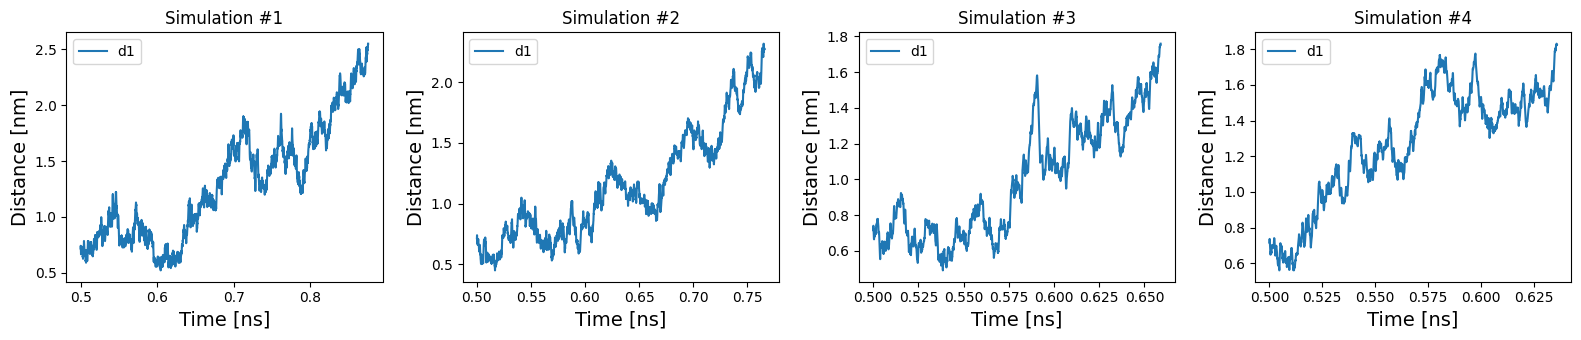

In [52]:

# visualize the data
plt.figure(figsize=(16,3.5))
for i, simulation_data in enumerate(data_list):
    # print(simulation_data.shape)

    distance = simulation_data[:,[0,-5]] # take time and the 426th columns of data that correspond to the distance
    bias = simulation_data[:,[-2,-1]]
    bias_distance = simulation_data[:,[0,-5]]
    traj_raw = simulation_data[:,[-4,-3]]

    time = bias_distance[:,0]/1000

    plt.subplot(1,4,i+1)
    # plot distance between the COM on ligand and COM on protein to observe the dissociation
    plt.plot(time,distance[:,1],label='d1')
    plt.xlabel('Time [ns]',fontsize=14)
    plt.ylabel('Distance [nm]',fontsize=14)
    plt.legend()
    plt.title('Simulation #%i'%(i+1))

#     #####
#     One-hot encoded initial state assignment: Using K-mean clustering
#     #####
    num_labels = 20
    data = list(zip(traj_raw[:,0],traj_raw[:,1]))
    kmeans = KMeans(n_clusters= num_labels , random_state=0).fit(data)

    one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
    one_hot_labels[np.arange(traj_raw.shape[0]),kmeans.labels_] = 1
    file_name = data_list_str[i]

    # Save one-hot encoded initial states
    np.save('data/labels_'+str(file_name)+'.npy', one_hot_labels)

    # Create and save all 425 different OP as an SPIB input with normalization
    FKBP_distance_mean = np.mean(simulation_data[:,1:29], axis=0)
    FKBP_distance_std = np.std(simulation_data[:,1:29], axis=0)

    np.save('data/FKBP_distance_data_mean.npy', FKBP_distance_mean)
    np.save('data/FKBP_distance_data_std.npy', FKBP_distance_std)

    distance_simulation_data = simulation_data[:,1:29]

    traj_path_SPIB_OP = (distance_simulation_data-FKBP_distance_mean)/FKBP_distance_std #normalized trajectory data
    np.save('data/normalized_traj_path_'+str(file_name)+'.npy', traj_path_SPIB_OP)

plt.tight_layout()

## RUN SPIB stage 2

In [53]:
# run SPIB with the selected hyperparameters in the sample_config.ini files on here 6 trajectories
!python SPIB_scripts/test_model_advanced.py -config data/sample_config.ini


tensor([0.0000, 0.0000, 0.0000, 0.4969, 0.0000, 0.0000, 0.0000, 0.1150, 0.0000,
        0.0000, 0.0000, 0.0262, 0.3619, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.588602
Update lr to 0.000010
Epoch: 1

Iteration 500:	Time 1.822962 s
Loss (train) 2.962349	KL loss (train): 3.580147
Reconstruction loss (train) 2.961991
Loss (test) 2.955718	KL loss (test): 3.689878
Reconstruction loss (test) 2.955349
tensor([0.0146, 0.0000, 0.0000, 0.5005, 0.0000, 0.0000, 0.0000, 0.2687, 0.0000,
        0.0000, 0.0000, 0.0424, 0.1697, 0.0000, 0.0041, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
State population change=0.247136
Update lr to 0.000010
Epoch: 2

tensor([0.3219, 0.0000, 0.0395, 0.1729, 0.0000, 0.0000, 0.0000, 0.4019, 0.0000,
        0.0000, 0.0000, 0.0346, 0.0000, 0.0000, 0.0054, 0.0000, 0.0000, 0.0000,
        0.0238, 0.0000])
State population change=0.500495
Update lr to 0.000010
Epoch: 3

Iteration 1000:	Time 3.746521 s
Loss (train) 2.95033

## Generate Plume file from learn RC for MetaD


In [71]:

%cd /content/SPIB_kinetics/SPIB_training/SPIB02

/content/SPIB_kinetics/SPIB_training/SPIB02


In [72]:
!python plumed_generator_v2.py

===== Second updated sigma for RC 1 and RC2 ======
[sigma_1,sigma_2] =  [0.2995523  0.26405105]


In [77]:
!cp data/plumed_metaD_ANN.dat ../../simulation/02_inMetaD/02_inMetaD1

In [80]:
!pwd
%cd ../../

/content/SPIB_kinetics/SPIB_training/SPIB02
/content/SPIB_kinetics


## Prepare for Second SPIB stage/ Final infrequent metadynamics

In [70]:
%%bash
for i in {2..4}; do
    cp -r simulation/02_inMetaD/02_inMetaD1 simulation/02_inMetaD/02_inMetaD$i
done

In [81]:
!tail simulation/01_metaD/01_metaD1/plumed_metaD_ANN.dat

METAD ...
LABEL=metad
ARG=l1r_1,l1r_2 SIGMA=0.2800000011920929,0.2800000011920929 HEIGHT=1.5 BIASFACTOR=10 TEMP=300.0 PACE=500
GRID_MIN=-30,-30 GRID_MAX=15,20 GRID_BIN=2500,3000
CALC_RCT RCT_USTRIDE=1
... METAD



PRINT ARG=d_r26_r1,d_r29_r1,d_r32_r1,d_r35_r1,d_r38_r1,d_r41_r1,d_r44_r1,d_r47_r1,d_r50_r1,d_r53_r1,d_r56_r1,d_r59_r1,d_r62_r1,d_r65_r1,d_r68_r1,d_r71_r1,d_r74_r1,d_r77_r1,d_r80_r1,d_r83_r1,d_r86_r1,d_r89_r1,d_r92_r1,d_r95_r1,d_r98_r1,d_r101_r1,d_r104_r1,d_r107_r1,h_bond,d1,l1r_1,l1r_2,metad.bias,metad.rbias STRIDE=10 FILE=COLVAR

In [82]:
## SIMULATION PARAMETERS + FILES
simutlation_steps = 2000000 # 500000*0.002 ps >> 1000ps = 1ns
plumed_file_name = 'plumed_metaD_ANN.dat'
threshold_val = 2.0 # Dissociation distance [nm]: Cut-off distance for simulation to stop when threshold value reached
number_simulation= 4
dir_path = '/02_inMetaD'

In [83]:
for i in range(1, number_simulation + 1):
    _, exec_time = md_sim.measure_execution_time(run_simulation_round, i, simutlation_steps, plumed_file_name, threshold_val,dir_path)
    print(f"Round {i} completed in {exec_time:.2f} seconds.")

***** Currently Running 4 round of simulation******
===== Load pre-Equilibrated system Checkpoint file =====
Simulating...
 
========== Committor Activated ==========
 
====== The Ligand has not dissociated yet ======
 
 
 ****  Current steps **** =   500 / 2000000
      ligand location = 0.72      
 ****  Current steps **** =   1000 / 2000000
      ligand location = 0.69      
 ****  Current steps **** =   1500 / 2000000
      ligand location = 0.74      
 ****  Current steps **** =   2000 / 2000000
      ligand location = 0.75      
 ****  Current steps **** =   2500 / 2000000
      ligand location = 0.71      
 ****  Current steps **** =   3000 / 2000000
      ligand location = 0.67      
 ****  Current steps **** =   3500 / 2000000
      ligand location = 0.71      
 ****  Current steps **** =   4000 / 2000000
      ligand location = 0.65      
 ****  Current steps **** =   4500 / 2000000
      ligand location = 0.70      
 ****  Current steps **** =   5000 / 2000000
      ligand l

In [84]:
orginal_path = os.path.abspath('.')

data_list_2=[]
data_list_str_2=[]

print('...Loading...')
for i in range(1,2):
    print('Simulation %i Trajectory'%(i))
    sim_path = '/simulation/02_inMetaD/02_inMetaD%i'%(i)
    os.chdir(orginal_path+sim_path)
    md_sim.remove_line_change_rows()
    # remove_line_change_rows()

    locals()['inMetaD{0}'.format(i)] = np.loadtxt('COLVAR')
    data_list_2.append(locals()['inMetaD{0}'.format(i)])
    data_list_str_2.append('inMetaD{0}'.format(i))

os.chdir(orginal_path)

...Loading...
Simulation 1 Trajectory


## Calculate residence time and curve fit

In [85]:
residence_t_data = []

# Loop over the data points in 'data_list'
for i in range(len(data_list_2)):
    simulation_data = data_list_2[i]
    # Extract the time and bias columns from the simulation data
    time = simulation_data[:,0]
    bias = simulation_data[:,-2]
    # Calculate the time step (dt)
    dt = (time[-1]-time[-2])*1e-12
    k_B = 8.314462
    T = 300
    kbT = k_B*T/1000

    # Calculate the acceleration factor
    acceleration = np.exp(bias/kbT)
    residence_t = acceleration*dt
    residence_t = np.sum(residence_t)
    # print(residence_t)
    # Add the calculated residence time to the list of residence time data
    residence_t_data.append(residence_t)


In [86]:
residence_t_data

[3.1922031437908134e-09]

# CURVE FIT

Now all the simulations + SPIB is DONE!
Moving on to our final steps of curve fit

In [87]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import expon
from scipy import stats

In [89]:
residence_t_extra = [6.073578128088235e-08,1.003164998646387e-08,1.3862575070607363e-08,3.725082341727042e-09,3.6861857709495075e-07,1.455014546436496e-07,5.205023997892425e-08,3.2797815094177653e-09,2.83081296485558e-07,5.207390725128164e-09,7.817918177687463e-09,2.722726763316545e-08]
np.save('simulation/residence_t_extra.npy',residence_t_extra)


In [90]:
residence_t_data_extra = np.load('simulation/residence_t_extra.npy')

def include_extra_data(residence_t_data,residence_t_data_extra, num_sample=4):
    random_values = np.random.choice(residence_t_data_extra, size=num_sample, replace=False)
    return np.concatenate((np.array(residence_t_data), random_values))

tau = [41.9889778]


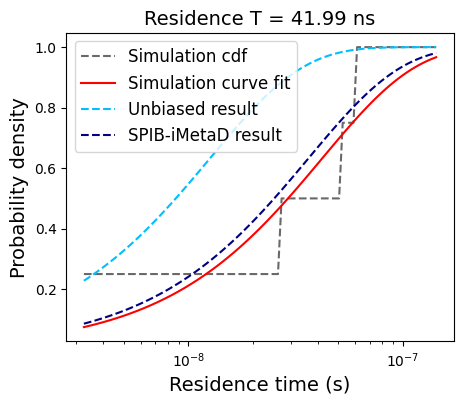

In [94]:
data = include_extra_data(residence_t_data,residence_t_data_extra,num_sample=4)

if len(data)<5:
    raise ValueError("The total number of data set is too small. Include more samples")

else:
    x_min, x_max = np.min(data),np.max(data)
    log_bin = np.logspace(np.log10(x_min),np.log10(x_max), 100)
    count, bins_count = np.histogram(data, bins=log_bin)
    bin_centers = 0.5 * (bins_count[1:] + bins_count[:-1])

    pdf = count/sum(count)
    cdf = np.cumsum(pdf)

    plt.figure(figsize=(5,4))
    plt.plot(bin_centers, cdf,'--',label='Simulation cdf',color="dimgray")
    plt.xlabel(r'Residence time (s)',fontsize=14)
    plt.ylabel('Probability density',fontsize=14)

    def fit_function(k, lamb):
        return expon.cdf(k,0,lamb)

    # curve_fit with the poisson cdf
    parameters, cov_matrix = curve_fit(fit_function, bin_centers, cdf)
    residenceT = parameters *10**9
    print('tau =',residenceT)

    fit_results = fit_function(bin_centers, parameters)
    plt.plot(bin_centers,fit_results,label='Simulation curve fit',color="red")

    # Unbiased result
    unbiased = 12.59 *10**-9
    unbiased_y = fit_function(bin_centers, unbiased)
    plt.plot(bin_centers,unbiased_y,'--',label='Unbiased result',color="deepskyblue")

    # SPIB-iMetaD result
    SPIB_metaD = 36.22 *10**-9
    SPIB_metaD_y = fit_function(bin_centers, SPIB_metaD)
    plt.plot(bin_centers,SPIB_metaD_y,'--',label='SPIB-iMetaD result',color="navy")

    plt.xscale('log')
    plt.legend(fontsize = 12)
    plt.title(r'Residence T = %3.2f ns'%residenceT,fontsize = 14)

    stats.kstest(data,expon.cdf,(0, parameters))
